# This Notebook creates some plots and analyses my_databse

**Channel 1-4**: "old cable", broke in middle

**Channel 5-8**: EGRT cable, installed for an EGRT. Could not installed until bottom of shaft. Some cable lays at surface.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
import math
from sklearn.metrics import r2_score

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year, import_tlogger
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, random_date,  save_values_in_file, plot_water_rise, create_mask_egrt 
from my_func_mvw.functions_dts_processing import watertank_shift, check_first_last_date, cut_dataframe_to_range_tlogger, check_processed_data, diff_to_watertank
%load_ext autoreload
%autoreload 2

plot_save=True #True False
masterthesis_save=False # True False
importer="pickle" #pickle currently only pickle is uesed 

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [ ]:
# To DO 
# create fix variables for notebook with bendpoint
# shaft begin

# these are the values in meter, also used in other plots for coloring
begin_borehole_0 = 506 #begin first round in shaft
end_borehole_0   = 1205

begin_borehole_1 = 2209 #begin second round in shaft
end_borehole_1   = 2908

In [2]:
# # Load csv data
path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
# data_2019 = import_my_database_csv(2019, path_DTS_processed + r"\csv")
# data_2020 = import_my_database_csv(2020, path_DTS_processed + r"\csv")
# data_2021 = import_my_database_csv(2021, path_DTS_processed + r"\csv")

# Load pickle Data
data_2021=import_my_database_pickle(2021, path_DTS_processed + r"\pickle")
data_2020=import_my_database_pickle(2020, path_DTS_processed + r"\pickle")
data_2019=import_my_database_pickle(2019, path_DTS_processed + r"\pickle")

data_all = read_pickle(path_DTS_processed + "\import_data_scripts\data_all")
# delete other cable channels
for old_chan in ["1","2","3","4"]:
    del data_all[old_chan]

# load some processed data
chan_mean_avearagefirst = read_pickle(path_DTS_processed + "\import_data_scripts\chan_mean_avearagefirst")
watertank_diff_log_data_all = read_pickle(path_DTS_processed + "\import_data_scripts\watertank_diff_log_data_all")
data_all_processed_shifted = read_pickle(path_DTS_processed + "\import_data_scripts\data_all_processed_shifted")
watertank_diff_log_avearagefirst = read_pickle(path_DTS_processed + "\import_data_scripts\watertank_diff_log_avearagefirst")
# chan_mean_shiftfirst = read_pickle(path_DTS_processed + "\..\import_data_scripts\chan_mean_shiftfirst")
data_all_processed = read_pickle(path_DTS_processed + "\import_data_scripts\data_all_processed")
Schacht_7and8_0_down = read_pickle(path_DTS_processed + r"\shaft_temperatures\egrt_cable\pickle" + "\\Schacht_7and8_down")
Schacht_7and8_0_up = read_pickle(path_DTS_processed + r"\shaft_temperatures\egrt_cable\pickle" + "\\Schacht_7and8_up")
shaft_chan_14={}
for chan in ["1","2","3","4"]:
    shaft_chan_14[chan] = read_pickle(path_DTS_processed + r"\shaft_temperatures\old_cable\pickle" + f"\\Schacht_chan_{chan}")
chan_mean_constshift_averagefirst = read_pickle(path_DTS_processed + "\import_data_scripts\mean_ch5-8_constshift_averagefirst")
# chan_mean_constshift_shiftfirst = read_pickle(path_DTS_processed + "\import_data_scripts\mean_ch5-8_constshift")
chan58_constshift = read_pickle(path_DTS_processed + "\import_data_scripts\data_ch5-8_processed_constshifted")
chan14_constshift = read_pickle(path_DTS_processed + "\import_data_scripts\data_ch1-4_processed_constshifted")
chan18_constshift={}
for chan in chan58_constshift.keys():
    chan18_constshift[chan]=chan58_constshift[chan]
for chan in chan14_constshift.keys():
    chan18_constshift[chan]=chan14_constshift[chan]
del chan58_constshift
del chan14_constshift

In [3]:
# Import TLogger
df_Tlogger, df_Tlogger_PT1000 = import_tlogger(path_DTS_processed=path_DTS_processed,importer=importer)
watertank_T_range_min = df_Tlogger.index.min()
watertank_T_range_max = df_Tlogger.index.max()

watertank_len=[24,1689,1723,3389] # position DTS cable (hybrid), where it is in watertank; vorher [25,1689,1723,3389] [19,1690,1723,3389]

df_Tlogger

,Channel1-Watertank,Channel2-Air,Channel1_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-10-06 10:49:47,17.7,NaN,17.7
2021-10-06 10:52:47,17.7,NaN,17.7
2021-10-06 10:55:47,17.7,NaN,17.7
2021-10-06 10:58:47,17.7,NaN,17.7


In [4]:
df_Tlogger_PT1000

,Channel1_PT1000,Channel2_PT1000,Channel1-PT1000_rolling_mean
2021-08-04 11:18:42,20.5,20.5,20.4
2021-08-04 11:21:42,20.4,20.5,20.4
2021-08-04 11:24:42,20.4,20.4,20.4
2021-08-04 11:27:42,20.4,20.4,20.4
2021-08-04 11:30:42,20.4,20.5,20.4
...,...,...,...
2021-10-06 10:49:47,17.7,17.5,17.7
2021-10-06 10:52:47,17.7,17.5,17.7
2021-10-06 10:55:47,17.7,17.5,17.7
2021-10-06 10:58:47,17.7,17.5,17.7


In [5]:
# plt.figure(figsize=(16,5))
# val=16000
# y=df_Tlogger["Channel1-rolling_mean"].values[val:]
# x_dates=df_Tlogger["Channel1-rolling_mean"].index[val:]
# plt.scatter(x_dates,y,label="Watertank-Temp rolling_mean",color="red",zorder=10)

In [6]:
# shorten T-logger so gaps are not in dataframe, I need to adapt my functions to the data gaps
# df_Tlogger = df_Tlogger.iloc[:15500]
# df_Tlogger

# Wireline T-Logger

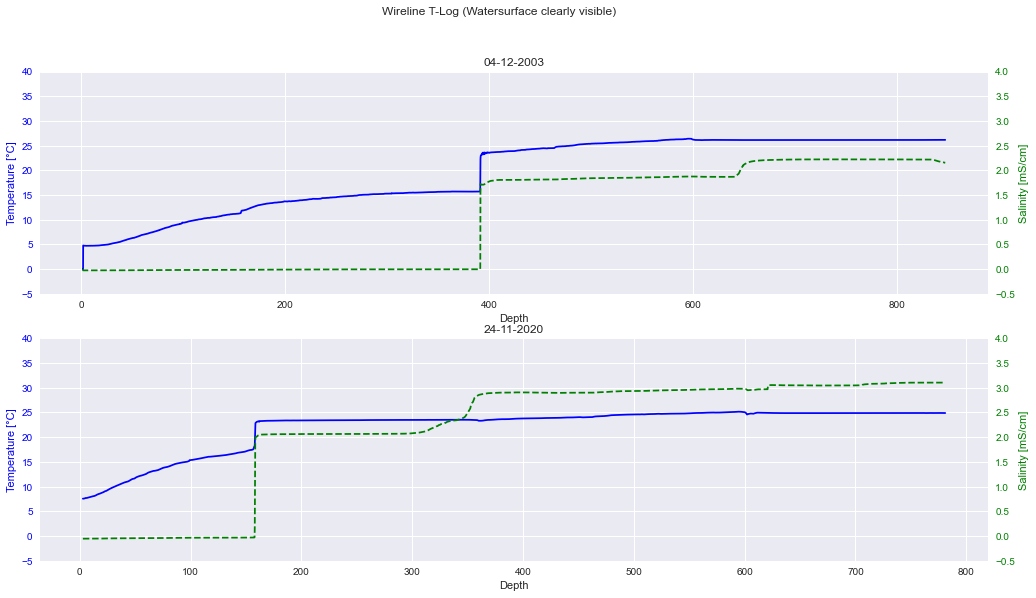

In [7]:
# Load Data
path_to_wireline = path_DTS_processed + "\..\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows
wireline_measurements2020

# Plot the data
##########Inputs##########
ymin=-5;ymax=40
cBHT="blue";cSAL="green"
lstyle_BHT="-";lstyle_SAL="--"
######################
fig,axs=plt.subplots(2,1,figsize=[17,9])#,constrained_layout=True)
fig.suptitle("Wireline T-Log (Watersurface clearly visible)")
#fig.tight_layout()

axs[0].set_title("04-12-2003") # First axes

axs[0].plot(wireline_measurements2003["BHT"].index,wireline_measurements2003["BHT"].values,color=cBHT,linestyle=lstyle_BHT)#label="Bottom Hole Temperature"
axs[0].set_xlabel("Depth")
axs[0].set_ylabel("Temperature [°C]",color=cBHT)
axs[0].set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs[0].tick_params(axis='y', labelcolor=cBHT)

axs0_2 = axs[0].twinx()
axs0_2.plot(wireline_measurements2003["SAL"].index,wireline_measurements2003["SAL"].values,color=cSAL,linestyle=lstyle_SAL)#,label="Salinity")
axs0_2.set_ylabel('Salinity [mS/cm]', color=cSAL)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cSAL)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines

axs[1].set_title("24-11-2020") # Second axes

axs[1].plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,color=cBHT,linestyle=lstyle_BHT)#label="Bottom Hole Temperature"
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Temperature [°C]",color=cBHT)
axs[1].set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs[1].tick_params(axis='y', labelcolor=cBHT)

axs1_2 = axs[1].twinx()
axs1_2.plot(wireline_measurements2020["SAL"].index,wireline_measurements2020["SAL"].values,color=cSAL,linestyle=lstyle_SAL)#,label="Salinity")
axs1_2.set_ylabel('Salinity [mS/cm]', color=cSAL)
axs1_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs1_2.tick_params(axis='y', labelcolor=cSAL)
# The grids are not alligned, if not using .set_ylim()
axs1_2.grid(None) #axs is behind the helper lines

#plt.legend()
plt.show()

# Wie genau funktioniert das gerät, es zeichnet nur den höchsten Wert auf oder?


In [8]:
# water level depth
#wireline_measurements2020["BHT"][157:159]
#wireline_measurements2003["BHT"][390:392]

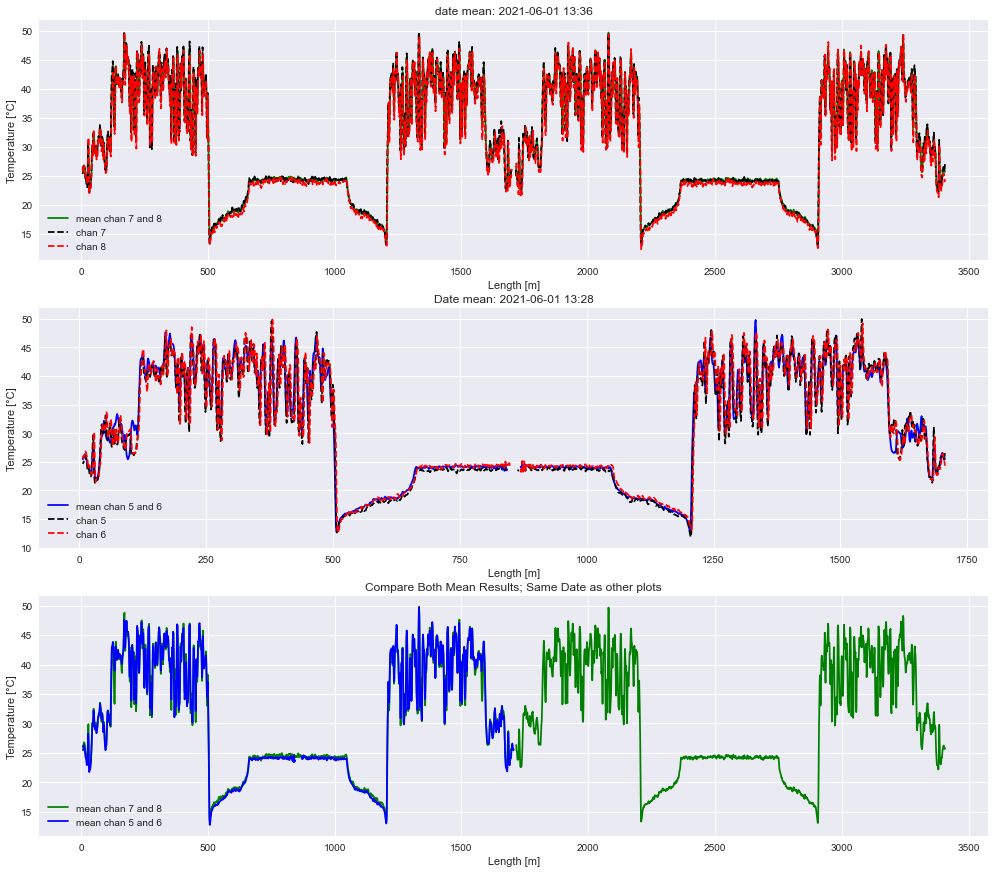

be aware, that for calculating the mean one courve has to be shifted for a few (4) minutes


In [9]:
# SOllte ich denke ich auf const shift ändern !!!!!!!!!!!

# Plot mean values compared to channel values
# the songle channels are plooted, like they are used in the mean calculation. Every point which is avearaged with an other ist plotted at the same position, therfore one channel has been flipped.
date_iloc=0 #change me
fig,axs=plt.subplots(3,1,figsize=[17,15])#,constrained_layout=True)

data=chan_mean_constshift_averagefirst["7and8"]
axs[0].plot(data.iloc[date_iloc].index,data.iloc[date_iloc].values, label="mean chan 7 and 8", color="green")
# get correspnding dates of chan 7 and 8
date_name_ch7, date_iloc_ch7 = find_nearest_date(data.iloc[date_iloc].name,chan18_constshift["7"].index)
date_name_ch8, date_iloc_ch8 = find_nearest_date(data.iloc[date_iloc].name,chan18_constshift["8"].index)
# flip channel 7, also done for mean calculation
axs[0].plot(chan18_constshift["7"].loc[date_name_ch7].index[::-1], chan18_constshift["7"].loc[date_name_ch7].values, label="chan 7",linestyle="--", color="black")
axs[0].plot(chan18_constshift["8"].loc[date_name_ch8].index, chan18_constshift["8"].loc[date_name_ch8].values, label="chan 8",linestyle="--", color="red")
axs[0].set_title(f"date mean: {data.iloc[date_iloc].name.strftime('%Y-%m-%d %H:%M') }") # drop seconds
axs[2].plot(data.iloc[0].index,data.iloc[date_iloc].values, label="mean chan 7 and 8", color="green")

data=chan_mean_constshift_averagefirst["5and6"]
axs[1].plot(data.iloc[date_iloc].index,data.iloc[date_iloc].values, label="mean chan 5 and 6", color="blue")
# get correspnding dates of chan 5 and 6
date_name_ch5, date_iloc_ch5 = find_nearest_date(data.iloc[date_iloc].name,chan18_constshift["5"].index)
date_name_ch6, date_iloc_ch6 = find_nearest_date(data.iloc[date_iloc].name,chan18_constshift["6"].index)
# flip channel 5, also done for mean calculation
axs[1].plot(chan18_constshift["5"].loc[date_name_ch5].index[::-1], chan18_constshift["5"].loc[date_name_ch5].values, label="chan 5",linestyle="--", color="black")
axs[1].plot(chan18_constshift["6"].loc[date_name_ch6].index, chan18_constshift["6"].loc[date_name_ch6].values, label="chan 6",linestyle="--", color="red")
axs[1].set_title(f"Date mean: {data.iloc[date_iloc].name.strftime('%Y-%m-%d %H:%M')}") # drop seconds
axs[2].plot(data.iloc[0].index,data.iloc[date_iloc].values, label="mean chan 5 and 6", color="blue")

axs[2].set_title(f"Compare Both Mean Results; Same Date as other plots")

for ax in axs:
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")
    ax.legend()

plt.show()
print("be aware, that for calculating the mean one courve has to be shifted for a few (4) minutes")

# Plot Data

In [177]:
def interactive_plot_function(data_type,channel,date,display_from,display_to,ymin,ymax,show_mean_chan5and6,show_mean_chan7and8,color_plot,plot_wireline,offset_wireline,offset_old_cable):

    if data_type == "data_all_unprocessed":
        data = data_all
    elif data_type == "data_all_processed_shifted":
        data = data_all_processed_shifted
    elif data_type == "data_all_constshifted":
        data = chan18_constshift
    
    # I need to define this function in here, so it can be used in interactive.
    def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, label=True):
        """ creates patches which color the plot"""
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax+ymin,color=col,alpha=0.2)
        axs.add_patch(Rectangle)
        if label and display_from < start_len+width/2 and display_to > start_len+width/2:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
            axs.text(start_len+width/2,ymax-(ymax-ymin)*0.1,label_name,ha="center",va="center",size=15,bbox=bbox_props)
    
    val={}
    fig,axs=plt.subplots(1,1,figsize=[18,5],constrained_layout=True)
    # Plot Data
    for chan in channel:
        length=data[chan].iloc[date].index[display_from:display_to]
        x=np.array(length).astype(int)
        val[chan]=np.array(data[chan].iloc[date].values)[display_from:display_to]
        date_name=data[chan].iloc[date].name
        y=val[chan]
        if chan in ["1","2","3","4"]:# both cables have a different legnth to the shaft
            if display_from <= offset_old_cable:
                length=data[chan].iloc[date].index[0:display_to-offset_old_cable]
                val[chan]=np.array(data[chan].iloc[date].values)[0:display_to-offset_old_cable]
            else:
                length=data[chan].iloc[date].index[display_from-offset_old_cable:display_to-offset_old_cable]
                val[chan]=np.array(data[chan].iloc[date].values)[display_from-offset_old_cable:display_to-offset_old_cable]
            x=np.array(length).astype(int)
            x=x+offset_old_cable
            y=val[chan]
        axs.plot(x,y,label=f"channel {chan}")

    if data_type == "data_all_unprocessed":
        axs.set_title(f"uncorrected data from {data[chan].iloc[date].name}")
    if data_type == "data_all_processed_shifted":
        axs.set_title(f"corrected processed data from {data[chan].iloc[date].name}")
    if data_type == "data_all_constshifted":
        axs.set_title(f"corrected constant shifted data from {data[chan].iloc[date].name}")
    if data_type == "nothing: select channel []":
        axs.set_title(f"plotted nothing")

    axs.set_ylim(ymin,ymax)
    axs.set_xlim(display_from,display_to)
    axs.set_xlabel("Length [m]")
    axs.set_ylabel("Temperature [°C]")

    if plot_wireline:
        #offset_wireline: offset, so that curve fits to EGRT cable
        length = wireline_measurements2003["BHT"].index + offset_wireline
        Temp   = wireline_measurements2003["BHT"].values
        axs.plot(length, Temp, label="Wireline T-Log\n04.12.2003")
        length = wireline_measurements2020["BHT"].index + offset_wireline
        Temp   = wireline_measurements2020["BHT"].values
        axs.plot(length, Temp, label="Wireline T-Log\n24.11.2020")

    # Avearage first
    # if show_mean_chan5and6:
    #     length_mean56=chan_mean_avearagefirst["5and6"].iloc[date].index[display_from:display_to]
    #     x=np.array(length_mean56).astype(int)
    #     y=chan_mean_avearagefirst["5and6"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
    #     date_name_chan56=chan_mean_avearagefirst["5and6"].iloc[date].name
    #     axs.plot(x, y,label=f"channel mean 5 and 6\nDate: {date_name_chan56}")

    # if show_mean_chan7and8:
    #     length_mean78=chan_mean_avearagefirst["7and8"].iloc[date].index[display_from:display_to]
    #     x=np.array(length_mean78).astype(int)
    #     y=chan_mean_avearagefirst["7and8"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
    #     date_name_chan78=chan_mean_avearagefirst["7and8"].iloc[date].name
    #     axs.plot(x, y,label=f"channel mean 7 and 8\nDate: {date_name_chan78}")
    
    # Shiftfirst
    if show_mean_chan5and6:
        length_mean56=chan_mean_constshift_averagefirst["5and6"].iloc[date].index[display_from:display_to]
        x=np.array(length_mean56).astype(int)
        y=chan_mean_constshift_averagefirst["5and6"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
        date_name_chan56=chan_mean_constshift_averagefirst["5and6"].iloc[date].name
        axs.plot(x, y,label=f"channel mean 5 and 6\nDate: {date_name_chan56}")

    if show_mean_chan7and8:
        length_mean78=chan_mean_constshift_averagefirst["7and8"].iloc[date].index[display_from:display_to]
        x=np.array(length_mean78).astype(int)
        y=chan_mean_constshift_averagefirst["7and8"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
        date_name_chan78=chan_mean_constshift_averagefirst["7and8"].iloc[date].name
        axs.plot(x, y,label=f"channel mean 7 and 8\nDate: {date_name_chan78}")
        
    #splice_pos=1707 # splice position of long cable, not exactly at middle due to pig tail
    #plt.vlines(splice_pos,5,40, color="black",label="splice position?")
    #plt.vlines([splice_pos+10,splice_pos-10,splice_pos+17,splice_pos-17],5,40,label="watertank position?")
    #plt.vlines([splice_pos+14,splice_pos-14],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")
    #plt.vlines([1580,1595],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")

    # # Positions Cable buried - txt field
    # size=11; y=25; ha="center"; va="center"
    # bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    # x=36
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
    # x=130
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
    #axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label="Approx. start of Alsdorf Data", colors="black",linestyles="-")

    if color_plot == True:
        # Beginn water?
        axs.vlines(668,ymin,ymax, color="blue", label="begin water")
        axs.vlines(1050,ymin,ymax, color="blue")
        color_cable_pos(668,1050,"blue",ymax,ymin,label_name="Water")
        axs.vlines(859,ymin,ymax, color="blue", linestyle="--", label="bend point") # Bend point?
        if "7" in channel or "8" in channel:
            axs.vlines(2368,ymin,ymax, color="blue")
            axs.vlines(2750,ymin,ymax, color="blue")
            color_cable_pos(2368,2750,"blue",ymax,ymin, label_name="Water")
            axs.vlines(2559,ymin,ymax, color="blue", linestyle="--") # Bend point?
        # this means the cable goes 355 m deep in the shaft: bend point - Surface: 859 - 504; 2559 - 2203
        # the water table is 668 - 504 = 164 m depth: water table - surface 
        # other numbers 2368 - 2203 = 165 m depth
        # Passt zur Ausbauskizze von 2019, da waren es 169 m

        # Cable Buried; two positions are buried: 1, 2
        color_cable_pos(31,41,"brown",ymax,ymin,label_name="Buried",label=False) #1
        color_cable_pos(121,134,"brown",ymax,ymin,label_name="Buried",label=False)#2
        color_cable_pos(1580,1593,"brown",ymax,ymin,label_name="Buried",label=False)#2
        color_cable_pos(1674,1684,"brown",ymax,ymin,label_name="Buried",label=False)#1
        if "7" in channel or "8" in channel:
            color_cable_pos(1732,1742,"brown",ymax,ymin,label_name="Buried",label=False)#1
            color_cable_pos(1820,1833,"brown",ymax,ymin,label_name="Buried",label=False)#1
            color_cable_pos(3280,3293,"brown",ymax,ymin,label_name="Buried",label=False)#2
            color_cable_pos(3374,3384,"brown",ymax,ymin,label_name="Buried",label=False)#1

        #Position cable Fence
        color_cable_pos(1593,1674,"green",ymax,ymin,label_name="Fence")
        color_cable_pos(41,121,"green",ymax,ymin,label_name="Fence")
        if "7" in channel or "8" in channel:
            color_cable_pos(1742,1820,"green",ymax,ymin,label_name="Fence")
            color_cable_pos(3293,3374,"green",ymax,ymin,label_name="Fence")

        #Position cable at surface 
        color_cable_pos(134,506,"yellow",ymax,ymin,label_name="Surface")
        color_cable_pos(1205,1580,"yellow",ymax,ymin,label_name="Surface")
        if "7" in channel or "8" in channel:
            color_cable_pos(1833,2209,"yellow",ymax,ymin,label_name="Surface")
            color_cable_pos(2908,3280,"yellow",ymax,ymin,label_name="Surface")

        #Position cable Watertank
        color_cable_pos(18,20,"blue",ymax,ymin,label_name="Watertank",label=False)
        axs.vlines(18,ymin,ymax, color="black", label="Watertank")
        axs.vlines(20,ymin,ymax, color="black")
        #data["5"].columns[-20] # --> 1689; -20 because last value corresponds to 0
        color_cable_pos(1689,1691,"blue",ymax,ymin,label_name="Watertank",label=False)
        axs.vlines(1689,ymin,ymax, color="black")
        axs.vlines(1691,ymin,ymax, color="black")
        if "7" in channel or "8" in channel:
            color_cable_pos(1722,1724,"blue",ymax,ymin,label_name="Watertank",label=False)
            axs.vlines(1722,ymin,ymax, color="black")
            axs.vlines(1724,ymin,ymax, color="black")
            color_cable_pos(3388,3390,"blue",ymax,ymin,label_name="Watertank",label=False)
            axs.vlines(3388,ymin,ymax, color="black")
            axs.vlines(3390,ymin,ymax, color="black")

    axs.legend()
    #save_path = "pictures/overview.png"
    #plt.savefig(save_path)
    plt.show()

In [178]:
# Color Plot for EGRT cable - Interactive
# maybe this libary is better:
# I think this includes some hovering information 
#https://plotly.com/python/creating-and-updating-figures/
#implementing hovering in matplotlib is rather difficult
#https://stackoverflow.com/questions/7908636/is-it-possible-to-make-labels-appear-when-hovering-mouse-over-a-point-in-matplot
#I use this libary:
#https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#interactive

interact(interactive_plot_function,
data_type=["data_all_constshifted","data_all_processed_shifted","data_all_unprocessed","nothing: select channel []"],
channel=[["5","6"],["7","8"],["5","6","7","8"],"1","2","3","4","5","6","7","8",["1","2","3","4"],["1","2","3","4","5","6","7","8"],[]],
date=widgets.IntSlider(min=0, max=5000, step=1, value=10), # not optimal
display_from=widgets.IntSlider(min=0, max=3350, step=10, value=0), 
display_to=widgets.IntSlider(min=10, max=3700, step=10, value=1950),
ymin=widgets.IntSlider(min=0, max=100, step=5, value=5),
ymax=widgets.IntSlider(min=5, max=100, step=5, value=50),
color_plot=True,
plot_wireline=False,
show_mean_chan5and6=False,
show_mean_chan7and8=False,
offset_wireline=widgets.IntSlider(min=0, max=3000, step=2, value=508), #value is same as end cable surface color
offset_old_cable=widgets.IntSlider(min=0, max=3000, step=2, value=306))
print("means are avearagefirst means (of one date, not all dates)")
#from last measurements; compare -20 and -265 for determine of colors; range 0 bis 310

# Ideen:
# this means the cable goes 355 m deep in the shaft: bend point - Surface: 859 - 504
# other numbers: 2559 - 2203 = 356 m
# the water table is 668 - 504 = 164 m depth: water table - surface 
# other numbers 2368 - 2203 = 165 m depth
# Passt zur Ausbauskizze von 2019, da waren es 169 m
# Ist seit der Wireline Messung das Wasser über 200 m angestiegen? Bedeutet Sprung in Wireline-log nicht beginn Wasser?

# Pegelmessung aus IP noch einfügen

############Werte noch mit Notizen von Kabellänge überprüfen!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# In sich sind die Werte nicht ganz stimmig! (ein paar Meter Abweichung)
#   --> coloring positionen noch leicht anpassen, sodass alle Flächen gleich groß sind

# Vergleiche Plots:
# S. 25 Green Abschlussbericht
# Anl_04_433_15_004.pdf
# Wireline Plot

# Differenz von Chan 1-4 zu Chan 5-8 in Schacht Luft liegt an position? Wo gehen die beiden Kabel genau lang?
# egrt Kabel geht durch seperaten Röhre

interactive(children=(Dropdown(description='data_type', options=('data_all_constshifted', 'data_all_processed_…

means are avearagefirst means (of one date, not all dates)


# Compare Differences of Corrected Data

In [12]:
diff_watertank_afterprocess_alldates=diff_to_watertank(data_all_processed,watertank_len=watertank_len, watertank_T_range_min = watertank_T_range_min,
                                                        watertank_T_range_max = watertank_T_range_max,df_Tlogger=df_Tlogger,)
diff_watertank_aftercorr_afterprocess_alldates=diff_to_watertank(data_all_processed_shifted,watertank_len=watertank_len,watertank_T_range_min=watertank_T_range_min,
                                                        watertank_T_range_max=watertank_T_range_max,df_Tlogger=df_Tlogger,)

In [13]:
# Calculate differences to watertank temperature at all waterank positions for all date range of T-Logger
def calc_mean_diff_watertank(data,watertank_len=watertank_len):
    """Calculate Mean values of differences at all watertank positions"""
    # Create Dataframe
    columns_mean=[]
    columns_stdev=[]
    columns = list(data.keys()) # channel numbers
    columns_stdev.append("n_data")
    for chan in columns: # change the column names
        columns_mean.append("mean: " + chan) 
        columns_stdev.append("stdev: " + chan)
    mean_diff = pd.DataFrame(index = watertank_len, columns = columns_mean)
    mean_diff.index.names    = ["Length [m]"]
    mean_diff.columns.names  = ["Channel"]
    stdev_diff = pd.DataFrame(index = watertank_len, columns = columns_stdev)
    stdev_diff.index.names   = ["Length [m]"]
    stdev_diff.columns.names = ["Channel"]

    # Calculate mean for every channel
    for chan in columns:
        if chan in ["5","6","5and6"]:
            for length in watertank_len[:2]:
                mean_diff[f"mean: {chan}"][length]  = np.nanmean(data[chan].loc[length])
                stdev_diff["n_data"][length] = len(data[chan].loc[length])
                stdev_diff[f"stdev: {chan}"][length] = np.nanstd(data[chan].loc[length])
        else: #channel 7 and 8
            for length in watertank_len:
                mean_diff[f"mean: {chan}"][length]  = np.nanmean(data[chan].loc[length])
                stdev_diff["n_data"][length] = len(data[chan].loc[length])
                stdev_diff[f"stdev: {chan}"][length] = np.nanstd(data[chan].loc[length])

    mean_stdev = pd.concat([mean_diff, stdev_diff], axis=1)
    return mean_stdev

In [14]:
print(f"curves are shifted at length {watertank_len[0]} m to watertank value")
print("at the other length they are compared to the watertank temperature")
print("these are the mean diffeneces of the absolute difference for each date")
# both means are the same, because in processing I did not change anything at the watertank position (26062021)
#mean_stdev_uncorrected = calc_mean_diff_watertank(diff_watertank_afterprocess_alldates)
mean_stdev = calc_mean_diff_watertank(diff_watertank_aftercorr_afterprocess_alldates)
print("Mean and standart deviation")
display(mean_stdev)

# Achtung mean Abweichung ist im Moment nicht von absoluten Werten berechnet!
#   evntl. noch neue Spalte in Berechnung für absolute Werte?

curves are shifted at length 24 m to watertank value
at the other length they are compared to the watertank temperature
these are the mean diffeneces of the absolute difference for each date
Mean and standart deviation


Channel,mean: 5,mean: 6,mean: 7,mean: 8,n_data,stdev: 5,stdev: 6,stdev: 7,stdev: 8
Length [m],,,,,,,,,
24,0.0,0.0,0.0,0.0,5550,0.0,0.0,0.0,0.0
1689,-0.726654,-0.192902,0.150251,0.288834,5550,0.203208,0.236954,0.257334,0.347143
1723,NaN,NaN,0.13709,1.19263,5550,NaN,NaN,0.255816,0.399371
3389,NaN,NaN,-0.714092,-1.263418,5550,NaN,NaN,0.325138,0.287794


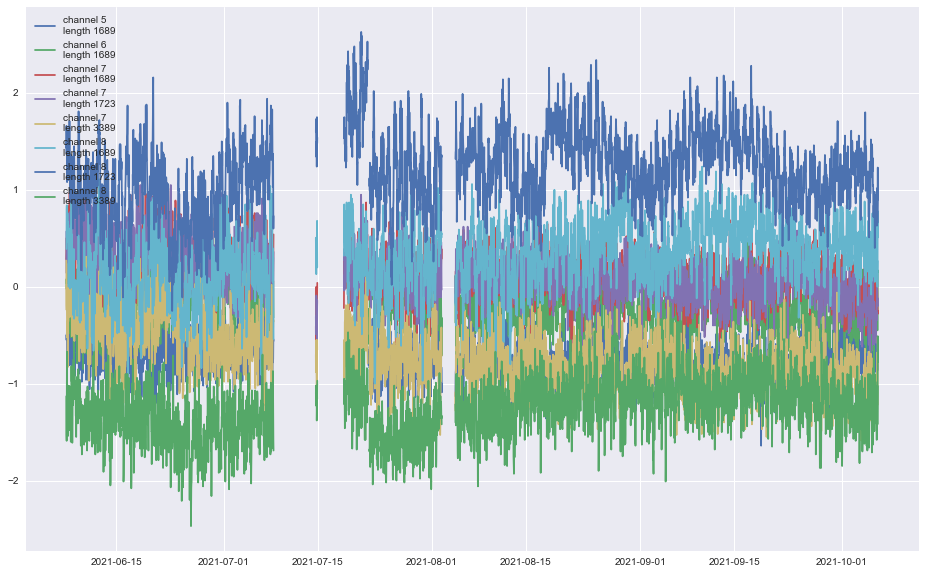

In [15]:
fig,axs=plt.subplots(1,1,figsize=[16,10])
dic_p = diff_watertank_aftercorr_afterprocess_alldates
for chan in ["5","6"]:
    ls = f"channel {chan}\nlength "
    axs.plot(dic_p[chan].loc[watertank_len[1]].index,dic_p[chan].loc[watertank_len[1]].values, label=ls+f"{watertank_len[1]}")
for chan in ["7","8"]:
    ls = f"channel {chan}\nlength "
    axs.plot(dic_p[chan].loc[watertank_len[1]].index,dic_p[chan].loc[watertank_len[1]].values, label=ls+f"{watertank_len[1]}")
    axs.plot(dic_p[chan].loc[watertank_len[2]].index,dic_p[chan].loc[watertank_len[2]].values, label=ls+f"{watertank_len[2]}")
    axs.plot(dic_p[chan].loc[watertank_len[3]].index,dic_p[chan].loc[watertank_len[3]].values, label=ls+f"{watertank_len[3]}")

axs.legend()
plt.show()

In [16]:
round_value=2
# diff watertank of the mean temperature between channels

# old way of calculations
# diff_watertank_shiftfirst = diff_to_watertank(chan_mean_constshift_shiftfirst,watertank_len=watertank_len, watertank_T_range_min = watertank_T_range_min,df_Tlogger_PT100=df_Tlogger, 
#                                                      watertank_T_range_max = watertank_T_range_max, shorten_input_date=True)#chan_mean_shiftfirst
# mean_stdev_shiftfirst = calc_mean_diff_watertank(diff_watertank_shiftfirst)
# mean_stdev_shiftfirst = mean_stdev_shiftfirst.replace(pd.NA, np.nan).round(round_value) # replace pd.nan because round does ont work
# print("mean and stdev to watertank, shift first")
# display(mean_stdev_shiftfirst)
# print()

diff_watertank_avearagefirst = diff_to_watertank(chan_mean_constshift_averagefirst,watertank_len=watertank_len, watertank_T_range_min = watertank_T_range_min,
                                                df_Tlogger=df_Tlogger,watertank_T_range_max = watertank_T_range_max, shorten_input_date=True) #chan_mean_avearagefirst
mean_stdev_avearagefirst = calc_mean_diff_watertank(diff_watertank_avearagefirst)
mean_stdev_avearagefirst = mean_stdev_avearagefirst.replace(pd.NA, np.nan).round(round_value)
print("mean and stdev to watertank, averaging first and after that watertank correction")
display(mean_stdev_avearagefirst)

mean and stdev to watertank, averaging first and after that watertank correction


Channel,mean: 5and6,mean: 7and8,n_data,stdev: 5and6,stdev: 7and8
Length [m],,,,,
24,-0.00,-0.02,5550,0.22,0.23
1689,-0.14,0.62,5550,0.21,0.25
1723,NaN,1.08,5550,NaN,0.24
3389,NaN,-0.16,5550,NaN,0.26


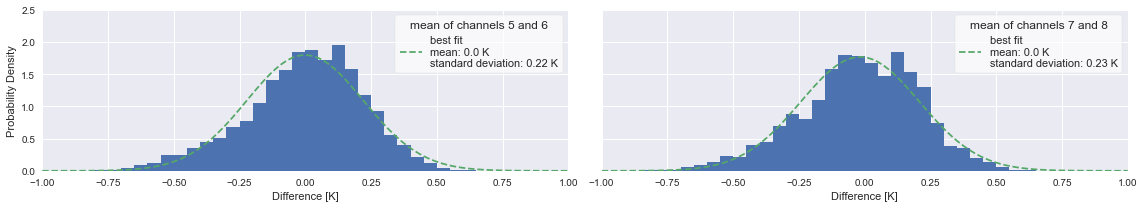

In [17]:
#differenced at first watertank position of processed data to reference temp
def plt_hist_in_axs(data,axes_tuple,chan,num_bins=30,binwidth=0.05):
    """"""
    mean=data.mean()
    stdv=data.std()

    hist_border=1 #1
    # n, bins, patches = ax.hist(data, num_bins, density=True)
    n, bins, patches = ax.hist(data,bins=np.arange(-hist_border, hist_border + binwidth, binwidth), density=True) #uses a binwidth
    x = np.linspace(-hist_border, hist_border, 100)
    from scipy.stats import norm
    ax.plot(x, norm.pdf(x, mean, stdv),linestyle="--",label=f"best fit\nmean: 0.0 K\nstandard deviation: {round(stdv,2)} K")
    # print(len(n)) #number of bins

    #Alternative plotting ways:
    # weights = np.ones_like(data)/float(len(data))
    # n, bins, patches =ax.hist(data, weights=weights)

    # y=((1 / (np.sqrt(2 * np.pi) * stdv)) * np.exp(-0.5 * (1 / stdv * (bins - mean))**2)) #best fit
    # ax.plot(bins, y, '--', label=f"best fit\nmean: 0.0 °C\nstandard deviation: {round(stdv,2)} K")

watertank_pos=24 #24 1689 1723 3389
fig,axs=plt.subplots(1,2,figsize=(16,3),sharey=True,tight_layout=True)
axes_tuples=[[0],[1]]
axes_counter=0
for chan in ["5and6","7and8"]:
    if chan in ["5and6","7and8"]:
        label_plot=f"{chan[0]} {chan[1:4]} {chan[4]}"
    else:
        label_plot=chan
    ax=axs[axes_tuples[axes_counter][0]]
    plt_hist_in_axs(diff_watertank_avearagefirst[chan].loc[watertank_pos],ax,chan)
    legend=ax.legend(fontsize=11, frameon=True,title_fontsize=12,title=f"mean of channels {label_plot}")
    legend.get_frame().set_alpha(0.7) #not supported with eps
    legend.get_frame().set_facecolor("white")
    ax.set_ylim(0,2.5)
    ax.set_xlim(-1,1)
    ax.set_xlabel("Difference [K]")
    axes_counter+=1

axs[0].set_ylabel("Probability Density")

if plot_save and watertank_pos==24:
    plt.savefig("pictures\diff_to_first_watertanl_probability_ch58.png",bbox_inches="tight")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\diff_to_first_watertanl_probability_ch58.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\diff_to_first_watertanl_probability_ch58.png", format="png",bbox_inches="tight",dpi=300)
plt.show()

# negative skewness, from EGRT heating

In [18]:
# Save these tables, they determine the error range of my final data
def save_df_as_image(df, path):
    """
    https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image
    """
    source = ColumnDataSource(df)
    df_columns = [df.index.name]
    df_columns.extend(df.columns.values)
    columns_for_table=[]
    for column in df_columns:
        columns_for_table.append(TableColumn(field=column, title=column))

    # height is im moment so etwas blöd, vorher viel zu groß
    # DataTable doc: 
    # http://docs.bokeh.org/en/latest/docs/reference/models/widgets.tables.html#bokeh.models.widgets.tables.DataTable
    data_table = DataTable(source=source, columns=columns_for_table,height=160,index_position=None)#height_policy="fit",width_policy="auto",
    export_png(data_table, filename = path)

# I only save shiftfirst, because I use this as my final values
path=r"./pictures/tables"
table_name = "/mean_stdev_avearagefirst.png"
save_df_as_image(mean_stdev_avearagefirst, path + table_name)

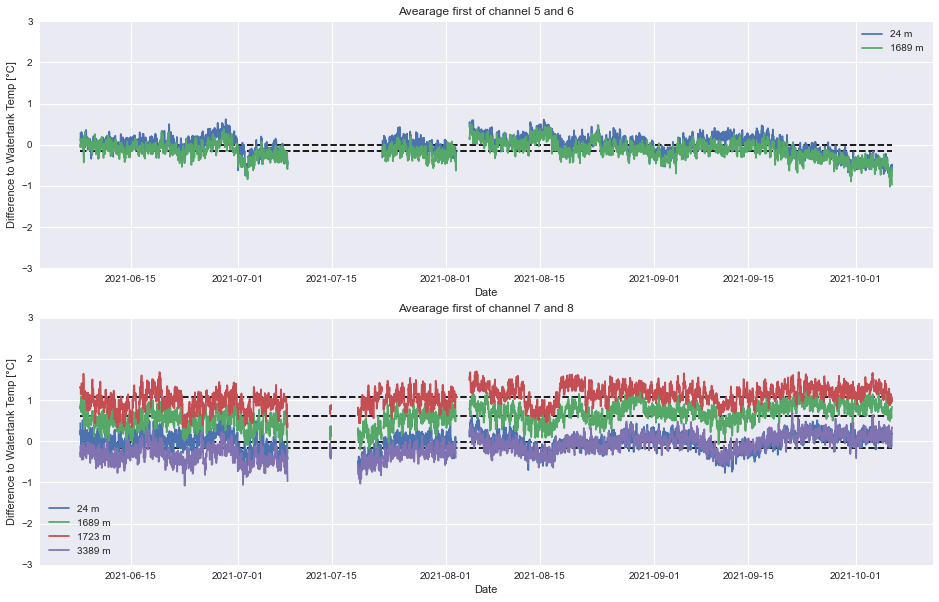

In [19]:
# Plot differences to watertank temperature over time: Avearege first
def plot_helper_9000(diff_watertank_data,mean_diff_data,w_positions,type,name):
    """w_positions: watertank position index you want to plot"""
    for w_pos in w_positions: #watertank position
        w_length = diff_watertank_data[name].index[w_pos] #watertank length
        index=diff_watertank_data[name].iloc[w_pos].index
        values=diff_watertank_data[name].iloc[w_pos].values
        ax.plot(index,values,label=f"{w_length} m")
        ax.hlines(mean_diff_data["mean: "+name].loc[w_length],index.min(),index.max(),linestyle="--",color="black")
    ax.legend()
    n=name.partition("and")
    ax.set_title(f"{type} of channel {n[0]} {n[1]} {n[2]}")
    ax.set_ylabel("Difference to Watertank Temp [°C]")
    ax.set_xlabel("Date")
    ax.set_ylim(-3,3)

fig,axs=plt.subplots(2,1,figsize=[16,10])
type_name="Avearage first"
counter_ax=0
for ax in axs[0:2]:
    if counter_ax==0:
        plot_helper_9000(diff_watertank_avearagefirst,mean_stdev_avearagefirst,[0,1],type=type_name, name="5and6")
        
    if counter_ax==1:
        plot_helper_9000(diff_watertank_avearagefirst,mean_stdev_avearagefirst,[0,1,2,3],type=type_name, name="7and8")
    counter_ax+=1

# # Plot differences to watertank temperature over time: Shift first
# type_name="Shift first"
# counter_ax=0
# for ax in axs[2:4]:
#     if counter_ax==0:
#         plot_helper_9000(diff_watertank_shiftfirst,mean_stdev_shiftfirst,[0,1],type=type_name,name="5and6")
        
#     if counter_ax==1:
#         plot_helper_9000(diff_watertank_shiftfirst,mean_stdev_shiftfirst,[0,1,2,3],type=type_name,name="7and8")
#     counter_ax+=1

if plot_save:
    name="avearage_temp_diff_watertank.png"
    plt.savefig("pictures/"+name)

plt.show()

In [20]:
calc_diff_of_single_channels_5_to_8=False # not important
if calc_diff_of_single_channels_5_to_8:
    # calc differnce between two channels

    # Difference for processed data
    diff_processed_data=defaultdict(dict)
    pairs=[["5","6"],["5","7"],["5","8"],["6","7"],["6","8"],["7","8"]]
    all_dates=[] #for determing date range later
    for pair in pairs:
        f_ch=pair[0] #first channel
        s_ch=pair[1] #second_channel

        data1 = data_all_processed_shifted[f_ch]
        data2 = data_all_processed_shifted[s_ch]


        ##############I should create an seperate named entry if one channel is flipped and adapt the following code
        ##########################################################################################

        # flip one dataframe, because its also done in avearaging two channels. 5 and 7 are flipped
        # for all others it doesnt matter, because I did not calculate a mean of them and because they are from different fibers
        if f_ch == "5" and s_ch =="6" or f_ch=="7" and s_ch=="8":
            data1_flipped=deepcopy(data1) # without deepcopy I would flip this dataframe for the rest of the notebook
            data1_flipped.columns = data1_flipped.columns[::-1]
            diff_processed_data[f"{f_ch} - {s_ch}"] = calc_diff_between_channels(data1_flipped,data2,diff_type_only_diff=True)
        else:
            diff_processed_data[f"{f_ch} - {s_ch}"] = calc_diff_between_channels(data1,data2,diff_type_only_diff=True)

    # only get dates for last pair
    dates=diff_processed_data[f"{f_ch} - {s_ch}"]["diff"].columns
    all_dates.append(dates)
    all_dates = np.array(all_dates)

    # Calculate mean difference (over time)
    def mean_diff_channels(dic_diff):
        """calc mean difference for each pair at the moment only for `normal diff` """
        diff_type="diff" #erstmal nur das benutzen (normale differenz)
        long_exists=False
        mean_diff = pd.DataFrame()
        mean_diff_long = pd.DataFrame() # channel 7-8 are longer, different dataframe needed or a lot of nan values in one dataframe
        for pair in dic_diff.keys():
            if pair == "7 - 8": # longer dataframe
                mean_diff_long[pair] = dic_diff[pair][diff_type].mean(axis=1)
                long_exists=True
            else:
                mean_diff[pair] = dic_diff[pair][diff_type].mean(axis=1)

        if long_exists==True:
            return mean_diff, mean_diff_long
        else:
            return mean_diff

    mean_diff, mean_diff_long = mean_diff_channels(diff_processed_data)

### Some Interpretation for mean_diff
* sollte `watertank_len[0]` length nicht 0 sein? 
  * --> Difference of watertank temperature (of my watertank temperature interpolating function) at the two different dates of both channels; So this somewhat shows the accuaracy of the PT Logger, when assuming the temperature should be constant.

In [21]:
# Difference between both avearage data
#diff_both_shiftfirst=defaultdict(dict)
pairs=["5and6","7and8"]
all_dates_avearagefirst=[] #for determing date range later
# all_dates_shiftfirst=[]

f_pair=pairs[0] #first avearage pair
s_pair=pairs[1] #second avearage pair

data1 = deepcopy(chan_mean_constshift_averagefirst[f_pair]) #chan_mean_avearagefirst
data2 = deepcopy(chan_mean_constshift_averagefirst[s_pair]) #chan_mean_avearagefirst
#flip to see how diff changes: has big influence!
# data2.columns=data2.columns[::-1]
# data1.columns=data1.columns[::-1]

diff_both_avearagefirst = calc_diff_between_channels(data1,data2)

# data1 = chan_mean_shiftfirst[f_pair]
# data2 = chan_mean_shiftfirst[s_pair]
# diff_both_shiftfirst[f"{f_pair} - {s_pair}"] = calc_diff_between_channels(data1,data2)

all_dates_avearagefirst.append(diff_both_avearagefirst["diff"].columns)
#all_dates_shiftfirst.append(diff_both_shiftfirst[f"{f_pair} - {s_pair}"]["diff"].columns)

all_dates_avearagefirst = np.array(all_dates_avearagefirst).flatten()
#all_dates_shiftfirst = np.array(all_dates_shiftfirst).flatten()

# Calculate mean
mean_diff_avearagefirst = diff_both_avearagefirst["diff"].mean(axis=1)
#mean_diff_shiftfirst = mean_diff_channels(diff_both_shiftfirst)

In [22]:
# Difference between both avearage data - second half of 7and8
#diff_both_shiftfirst=defaultdict(dict)
pairs=["5and6","7and8"]

f_pair=pairs[0] #first avearage pair
s_pair=pairs[1] #second avearage pair

data1 = deepcopy(chan_mean_constshift_averagefirst[f_pair])
col=chan_mean_constshift_averagefirst[s_pair].columns[1700:]
data2 = deepcopy(chan_mean_constshift_averagefirst[s_pair][col]) #use second half of 7and8

# manually adjust missmatch; looks better in diff
# later one is flipped, so remove data from same side
col=data1.columns[1:]
data1=data1[col]
col=data2.columns[1:]
data2=data2[col]

# like this 1723 of 7and8 becomes 24
# 24 is water tank position of 5and6
# only column names are important for diff calculation
data2.columns=data2.columns-1699 

#flip to see how diff changes: has big influence!
# data2.columns=data2.columns[::-1]
data1.columns=data1.columns[::-1] # one hase to be flipped, see scetch of fibers in methods of thesis

diff_both_avearagefirst_secondhalf78 = calc_diff_between_channels(data1,data2)

# Calculate mean
mean_diff_avearagefirst_secondhalf78 = diff_both_avearagefirst_secondhalf78["diff"].mean(axis=1)
#mean_diff_shiftfirst = mean_diff_channels(diff_both_shiftfirst)

In [23]:
# difference between 78 and 1 to 4
mask_not_egrt_78=create_mask_egrt(Schacht_7and8_0_down) #get mask that rempves egrt dates
diff_78_14={}
col=Schacht_7and8_0_down.columns
for chan in ["1","2","3","4"]:
    mask_not_egrt_14=create_mask_egrt(shaft_chan_14[chan].iloc[59744:][col])
    # calc_diff_function searches for the nearest date in the other dataframe
    diff_78_14[chan]=calc_diff_between_channels(shaft_chan_14[chan].iloc[59744:][mask_not_egrt_14][col],Schacht_7and8_0_down[mask_not_egrt_78][:-2],expected_difference_minutes=30)


Warning 1: large time difference
0 days 01:29:06
Warning 1: large time difference
0 days 00:52:44
Warning 1: large time difference
0 days 01:25:06
Warning 1: large time difference
0 days 00:48:44
Warning 1: large time difference
0 days 01:21:05
Warning 1: large time difference
0 days 00:44:24
Warning 1: large time difference
0 days 01:17:05
Warning 1: large time difference
0 days 00:40:24


# Plot differences

In [24]:
def plot_one_ax_mean_diff(mean_diff,mean_diff_long,pairs):
        """plots the mean diff between two channels"""
        mean_diff_plot=mean_diff
        
        for pair in pairs:
                if pair == "7 - 8":
                        ax.plot(mean_diff_long[pair].index,mean_diff_long[pair].values,label=pair)
                        mean = np.nanmean(mean_diff_long[pair].values)
                        ax.hlines(mean,0,3400,linestyle="--", color="black",label = "mean")
                else:
                        ax.plot(mean_diff_plot[pair].index,mean_diff_plot[pair].values,label=pair)
                        mean=np.nanmean(mean_diff_plot[pair].values)
                        ax.hlines(mean,0,1700,linestyle="--",color="black")

        ax.set_xlabel("Length [m]")
        ax.set_ylabel(f"Difference [°C]")
        #bei größerer Zeitspanne ggf .date benutzen um sekunden wegzulassen
        mi_date=pd.Timestamp(all_dates.min()).round(freq="H")
        ma_date=pd.Timestamp(all_dates.max()).round(freq="H")
        ax.set_title(f"Mean Difference between processed corrected values\nfrom {mi_date} to {ma_date}")
        ax.legend()

# This plot is not very usefull, because complete curve is shifted for half of the trend which is cancelled during averaging
if calc_diff_of_single_channels_5_to_8:
        # Plot mean differences of corrected processed Temperature
        # I could also plot other diff like relative or absolute
        fig,axs=plt.subplots(1,1,figsize=[16,6])
        pairs=["5 - 6","7 - 8"]#,"5-7","5-8","6-7","6-8"] #pairs for plotting, have to be in mean_diff.keys()
        ax=axs
        plot_one_ax_mean_diff(mean_diff,mean_diff_long,pairs)

        if plot_save:
                name="temp_difference_chan56_chan78.png"
                plt.savefig("pictures/"+name)
        plt.show()
        # plot the channel data, from a random date, so that the datapoints which are used for the mean calculation are plotted at the same length
        # to take a look if I should delete some length
        # ax.scatter(data_all_processed_shifted["5"].iloc[30].index[::-1],data_all_processed_shifted["5"].iloc[30].values,label="channel 5; one date",s=1)
        # ax.scatter(data_all_processed_shifted["6"].iloc[30].index,data_all_processed_shifted["6"].iloc[30].values,label="channel 6; one date",s=1)
        # ax.vlines([505,663],-5,30,color="black",label="helperline",zorder=0,linewidth=1)
        # ax.legend()

        # High peaks mean, that maybe each cable position is not substracted from its partner. Length description could be wrong
        # Ich denke aber, dass dies hier nicht der Fall ist.
        # High peaks at 5 and 6 in the middle are from fibre damage? these channels show a very high peak when plotting them individually. I guess the fibre is damaged (mechanical highly influenced) and therfore influences the data around it
        # vorallem bei 7 - 8 ist auch ein Trend zu sehen der durch das avearage ausgeglichen wird; Bei 5 - 6 ist dieser eher nur zu erahnen
        # Evntl sind channel 5 und 6 um einen Messpunkt noch verschoben, da bei diff von Channel 7 und 8 der Wasserübergang nicht als Steigung in Differenz auftaucht. Habe löschen probiert peaks (bei ca. 700 und 1100) gingen nicht weg.

        # Trend der über die Länge zu sehen ist (besser in 7 - 8), kommt im Endeffekt (auch) von der Verschiebung auf das Wassertank Nivaue. Da ich das bei jedem Channel bei der watertank_len[0] position mache. Nach dem flippen ist also der eine Channel am Anfang (nahe bei 0) und der andere am Ende auf das Wassertank Nivaue korrigiert.

Mean Difference between both avearage approaches
from 2021-06-01 14:00:00 to 2021-11-04 09:00:00
avearage of channel 5, 6 minus avearage of 7, 8

mean -0.030119768384286746
mean shaft 0.13484100783532293


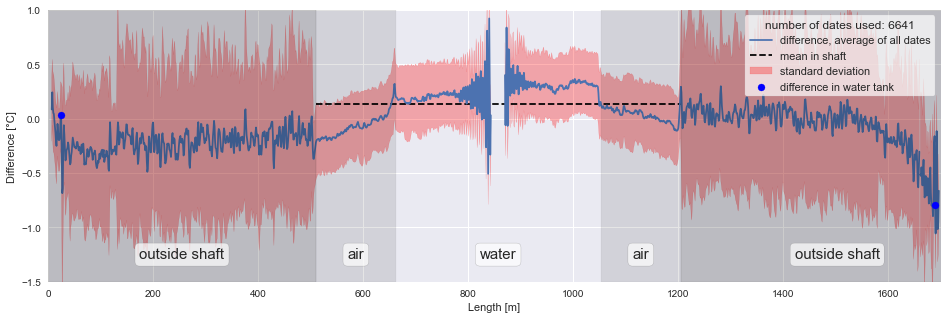

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
second half of 7and8:

Mean Difference between both avearage approaches
from 2021-06-01 14:00:00 to 2021-11-04 09:00:00
avearage of channel 5, 6 minus avearage of 7, 8

mean -0.022646662575101843
mean shaft 0.1170519459560564


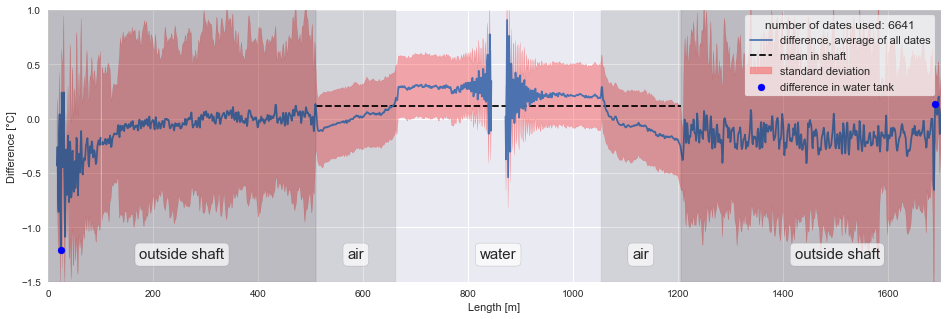

In [25]:
def plot_one_ax_mean_diff_2(mean_diff, name,label,ax):
        """plots the diffs list, each in one axis; only used in this cell"""
        pairs=["5and6 - 7and8"]

        # extract channel name from pairs
        partition0=pairs[0].partition("-")
        chan1=partition0[0].partition("and")[0]
        chan2=partition0[0].partition("and")[2][0]
        chan3=partition0[2].partition("and")[0][1]
        chan4=partition0[2].partition("and")[2]

        ax.plot(mean_diff.index,mean_diff.values,label=f"{label}",zorder=10)

        ax.set_xlabel("Length [m]")
        ax.set_ylabel(f"Difference [°C]")
        #bei größerer Zeitspanne ggf .date benutzen um sekunden wegzulassen
        if name == "avearagefirst":
                all_dates=all_dates_avearagefirst
        elif name == "shiftfirst":
                all_dates=all_dates_shiftfirst
        mi_date=pd.Timestamp(all_dates.min()).round(freq="H")
        ma_date=pd.Timestamp(all_dates.max()).round(freq="H")
        print(f"Mean Difference between both avearage approaches\nfrom {mi_date} to {ma_date}\navearage of channel {chan1}, {chan2} minus avearage of {chan3}, {chan4}")

def plot_diff_78_56(mean_diff,diff_both,ymin=-1.5,ymax=1,save_values_for_tex=False,plot_one_ax_mean_diff_2=plot_one_ax_mean_diff_2):
        """""" 
        def color_cable_pos_mean_diff(start_len, end_len, col, ymax, ymin, label_name,alpha=0.5, label=True):
                """ creates patches which color the plot"""
                width = end_len - start_len
                Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=abs(ymax)+abs(ymin),color=col,alpha=alpha,zorder=19)
                axs.add_patch(Rectangle)
                if label:
                        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
                        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.7)
                        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=15,bbox=bbox_props,zorder=20)


        # Plot mean differences of corrected processed avearged Temperature
        fig,axs=plt.subplots(1,1,figsize=[16,5])#,constrained_layout=True)

        plot_one_ax_mean_diff_2(mean_diff,"avearagefirst",label="difference, average of all dates",ax=axs)

        mean=np.nanmean(mean_diff.values)
        # only in shaft (incl. air)
        mean_shaft=diff_both["diff"][510:1205].mean(axis=1).mean()
        std_shaft=diff_both["diff"][510:1205].mean(axis=1).std()
        std_mean_shaft=diff_both["diff"][508:1205].std(axis=1).mean()

        axs.hlines(mean_shaft,510,1205,linestyle="--",color="black",label="mean in shaft")
        print();print(f"mean {mean}"); print(f"mean shaft {mean_shaft}")
        if save_values_for_tex:
                save_values_in_file(5,"mean_diff_56_minus_78_final_average_shaft",round(mean_shaft,2),r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")
                save_values_in_file(6,"std_mean_diff_56_minus_78_final_average_shaft",round(std_mean_shaft,2),r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")
                save_values_in_file(7,"std_diff_56_minus_78_final_average_shaft",round(std_shaft,2),r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")
        # plot_one_ax_mean_diff_2(mean_diff_shiftfirst, "shiftfirst")
        # mean=np.nanmean(mean_diff_shiftfirst["5and6 - 7and8"].values)
        # ax.hlines(mean,0,1700,linestyle="--",color="black")

        # Plot stdv
        max_diff=diff_both["diff"].max(axis=1)
        min_diff=diff_both["diff"].min(axis=1)
        std=diff_both["diff"].std(axis=1)
        # axs.plot(mean_diff.values-std,color="red",label="standard deviation",alpha=1,zorder=9,linewidth=0.7)
        # axs.plot(mean_diff.values+std,color="red",alpha=1,zorder=9,linewidth=0.7)
        axs.fill_between(mean_diff.index, mean_diff.values-std, mean_diff.values+std, color="red",alpha=0.3,label="standard deviation")

        # Color cable enviroement
        color_cable_pos_mean_diff(0, 510, "black", ymax, ymin, "outside shaft",alpha=0.2)
        color_cable_pos_mean_diff(1205, 1800, "black", ymax, ymin, "outside shaft",alpha=0.2)
        color_cable_pos_mean_diff(510, 662, "black", ymax, ymin, "air",alpha=0.1)
        color_cable_pos_mean_diff(1052, 1205, "black", ymax, ymin, "air",alpha=0.1)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.7)
        start_len=662 ;width=1052-start_len
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,"water",ha="center",va="center",size=15,bbox=bbox_props,zorder=20)

        # Plot watertank position
        axs.scatter([24,1689],[mean_diff.loc[24],mean_diff.loc[1689]],
                        color="blue",label="difference in water tank",zorder=20)
        # bbox_props=dict(boxstyle="larrow",fc="white", ec="0.5", alpha=0.7)
        # axs.text(24+80,0.02,"water tank",color="blue",ha="center",va="center",size=12,bbox=bbox_props,zorder=20)
        # bbox_props=dict(boxstyle="rarrow",fc="white", ec="0.5", alpha=0.7)
        # axs.text(1689-80,-0.25,"water tank",color="blue",ha="center",va="center",size=12,bbox=bbox_props,zorder=20)
        # axs.vlines([24,1689],ymin,ymax,color="blue",label="water tank",linestyle="--",zorder=25,alpha=0.5,linewidth=3)

        # Assecoirs
        nan_columns=diff_both["diff"].isnull().all().sum() #number of columns hwich contain only nans
        n_columns=len(diff_both["diff"].columns)
        used_dates=n_columns-nan_columns
        legend=axs.legend(loc="upper right",fontsize=11, frameon=True,title_fontsize=12, title=f"number of dates used: {used_dates}")
        legend.get_frame().set_alpha(0.7) #not supported with eps
        legend.get_frame().set_facecolor("white")
        legend.set_zorder(30)
        axs.set_ylim(ymin,ymax)
        axs.set_xlim(0,1700)

plot_diff_78_56(mean_diff_avearagefirst,diff_both_avearagefirst,save_values_for_tex=masterthesis_save)
if plot_save:
        if masterthesis_save:
                plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\compare_result_avearages.pdf", format="pdf",bbox_inches="tight")
                plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\compare_result_avearages.png", format="png",bbox_inches="tight",dpi=300)
        plt.savefig(r".\pictures\compare_result_avearages.png",bbox_inches="tight")
plt.show()
# Egal welchen Berechnungsanstaz ich nehme DIfferenzen sind sehr ähnlich zwischen beiden avearage Paaren. Konst offset + eine sehr kleine Schwankung
# mean=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).mean()
# mini=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).min()
# maxi=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).max()
# print(f"mean {mean}")
# print(f"min {mini}")
# print(f"max {maxi}")

print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("second half of 7and8:")
print()
plot_diff_78_56(mean_diff_avearagefirst_secondhalf78,diff_both_avearagefirst_secondhalf78)
if plot_save:
        if masterthesis_save:
                plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\compare_result_avearages_secondhalf78.pdf", format="pdf",bbox_inches="tight")
                plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\compare_result_avearages_secondhalf78.png", format="png",bbox_inches="tight",dpi=300)
        plt.savefig(r".\pictures\compare_result_avearages.png",bbox_inches="tight")
plt.show()

In [26]:
# # increased diff at end because of splicing of channel 78
# # schwer zu sagen
# chan_mean_constshift_averagefirst["7and8"].mean(axis=0).loc[1400:1690].plot(label="7and8")
# # Als Vergleich
# chan_mean_constshift_averagefirst["5and6"].mean(axis=0).loc[1400:1690].plot(label="5and6")
# sdf=std.loc[1400:1690]
# plt.fill_between(sdf.index, sdf.values+22, -sdf.values+22, color="red",alpha=0.3,label="standard deviation od diff")
# plt.legend()
# plt.show()




######
# 78 andere Seite mit 56 vergleichen

channel 1, mean std in water: 0.36
channel 1, mean mean in water: 0.15

channel 2, mean std in water: 0.35
channel 2, mean mean in water: -0.1

channel 3, mean std in water: 0.48
channel 3, mean mean in water: -0.1

channel 4, mean std in water: 0.39
channel 4, mean mean in water: 0.03



all channels, mean mean in water: -0.005


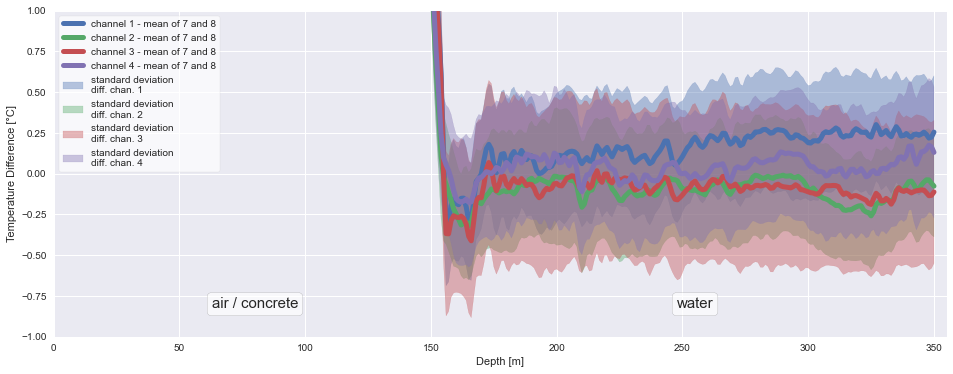

In [27]:
# plot difference 78 to 1-4 in shaft
ymin=-1;ymax=1
fig,axs=plt.subplots(1,1,figsize=[16,6])#,constrained_layout=True)
mean_all_shaftwater=0
for chan in ["1","2","3","4"]:
    mean=diff_78_14[chan]["diff"].mean(axis=1)
    std=diff_78_14[chan]["diff"].std(axis=1)
    std_mean_water=std[155:].mean() #160 rather rough
    mean_of_mean_shaftwater=mean[155:].mean()
    print(f"channel {chan}, mean std in water: {round(std_mean_water,2)}")
    print(f"channel {chan}, mean mean in water: {round(mean_of_mean_shaftwater,2)}")
    print()
    mean_all_shaftwater+=mean_of_mean_shaftwater

    mean_line,=axs.plot(mean.index,mean.values,label=f"channel {chan} - mean of 7 and 8",linewidth=5)

    # axs.plot(mean.index,mean.values+std,color=mean_line.get_color(),linewidth=0.3,label=f"standard deviation: {chan} - 78")
    # axs.plot(mean.index,mean.values-std,color=mean_line.get_color(),linewidth=0.3)
    axs.fill_between(mean.index,mean.values-std,mean.values+std,color=mean_line.get_color(),alpha=0.4,label=f"standard deviation\ndiff. chan. {chan}")
print();print()
print(f"all channels, mean mean in water: {round(mean_all_shaftwater/4,3)}")

bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.7)
axs.text(0+160/2,ymax-(ymax-ymin)*0.9,"air / concrete",ha="center",va="center",size=15,bbox=bbox_props)
axs.text(160+(350-160)/2,ymax-(ymax-ymin)*0.9,"water",ha="center",va="center",size=15,bbox=bbox_props)

axs.set_xlabel("Depth [m]")
axs.set_ylabel("Temperature Difference [°C]")
axs.set_ylim(ymin,ymax)
axs.set_xlim(0,355)
legend=axs.legend(fontsize=10, frameon=True,title_fontsize=11)
legend.get_frame().set_alpha(0.7) #not supported with eps
legend.get_frame().set_facecolor("white")
if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\compare_result_14-78.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\compare_result_14-78.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig(r".\pictures\compare_result_14-78.png",bbox_inches="tight")
plt.show()

# Trend analysis

channel 5
m: -0.0002968113972752476; b: 22.716986936343744; r2: 0.004455762332967073
5and6 average, m: 3.120630013628367e-08; b: 19.95219694774875; r2: 3.6389335988928906e-11

channel 6
m: -0.00015231844283186273; b: 24.71455321570039; r2: 0.001154679934058156

channel 7
m: -0.00013088483123439116; b: 12.371627174985; r2: 0.00427565449635392
only data from shaft water, m: -0.00013320639375415715; b: 15.21839263997221; r2: 0.8350861338631463
7and8 average, m: -1.7370757602321943e-05; b: 20.200382830430517; r2: 5.504706471337606e-05
7and8 average in shaft water, m: -5.136867849451069e-07; b: 24.027708527660124; r2: 9.250540174909894e-05

channel 8
m: -0.00025568886215424254; b: 20.835325991397617; r2: 0.014410314042649142
only data from shaft water, m: -0.00021580417090019885; b: 23.807928380941224; r2: 0.8915871450972186



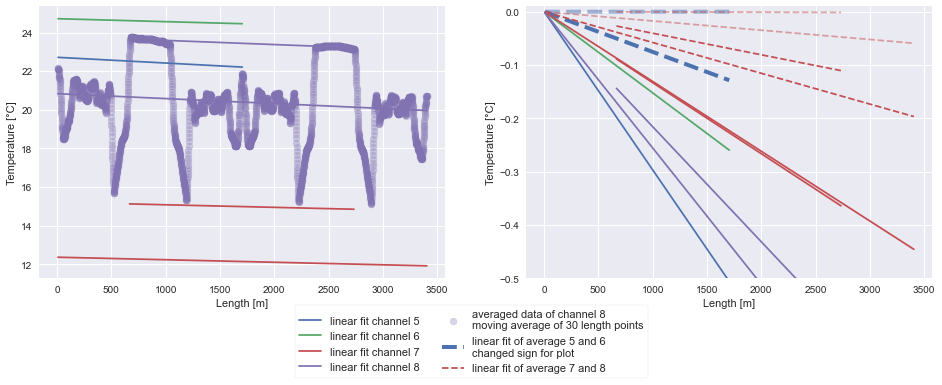

In [28]:
# Analyse trend in data
master_txt_save=r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt"
fig, axs=plt.subplots(1,2,figsize=(16,5))
border1=1 #number of length to skip at beginning
border2=1 #number of length to skip at end
me=data_all_processed["7"].mean(axis=0)
first_water_mask=np.logical_and(np.where(me.index > 665,True,False),np.where(me.index < 1035,True,False))
second_water_mask=np.logical_and(np.where(me.index > 2365,True,False),np.where(me.index < 2735,True,False))
both_water_mask=np.logical_or(first_water_mask,second_water_mask)
file_writer_cound=0
file_writer_start=8
for chan in ["5","6","7","8"]:
    print(f"channel {chan}")
    # x= data_all_processed[chan].mean(axis=0).index
    # y= data_all_processed[chan].mean(axis=0).values
    # plt.plot(x,y)
    window_size=30
    x=data_all_processed[chan].mean(axis=0)[border1:-border2].rolling(window_size,min_periods=3, center = True).mean().index
    y=data_all_processed[chan].mean(axis=0)[border1:-border2].rolling(window_size,min_periods=3, center = True).mean().values
    mb,cov = np.polyfit(x, y, 1,cov=True)
    predict=np.poly1d(mb)
    r2=r2_score(y, predict(x))
    linefit_chan, =axs[0].plot(x,x*mb[0]+mb[1],label=f"linear fit channel {chan}")
    # plot them in seperate axes to compare only m
    axs[1].plot(x,x*mb[0]+0,label=f"linear fit channel {chan}",color=linefit_chan.get_color())
    if masterthesis_save: # Save information so I can read them in my tex file
        save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_chan{chan}_m",round(mb[0]*10**3,2),master_txt_save)
        file_writer_cound+=1
        if r2 < 0.1:
            r2_tex=r"\textless\space 0.1"
        else:
            r2_tex=round(r2,1)
        save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_chan{chan}_r2",r2_tex,master_txt_save)
        file_writer_cound+=1
    print(f"m: {mb[0]}; b: {mb[1]}; r2: {r2}")
    if chan in ["8"]:
        axs[0].scatter(x,y, label=f"averaged data of channel {chan}\nmoving average of {window_size} length points",color=linefit_chan.get_color(),zorder=1, alpha=0.3)

    if chan in ["7","8"]:
        me=data_all_processed[chan].mean(axis=0)
        x=me[both_water_mask].index
        y=me[both_water_mask].values
        mb,cov = np.polyfit(x, y, 1,cov=True)
        axs[0].plot(x,x*mb[0]+mb[1],color=linefit_chan.get_color())
        axs[1].plot(x,x*mb[0]+0,color=linefit_chan.get_color())
        predict=np.poly1d(mb)
        r2=r2_score(y, predict(x))
        if masterthesis_save: # Save information so I can read them in my tex file
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_only_shaft_water_chan{chan}_m",round(mb[0]*10**3,2),master_txt_save)
            file_writer_cound+=1
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_only_shaft_water_chan{chan}_r2",round(r2,1),master_txt_save)
            file_writer_cound+=1
        print(f"only data from shaft water, m: {mb[0]}; b: {mb[1]}; r2: {r2}")

    #plot averaged linear fit results
    if chan=="7":
        x=chan_mean_constshift_averagefirst["7and8"].mean(axis=0)[border1:-border2].rolling(window_size,min_periods=3, center = True).mean().index
        y=chan_mean_constshift_averagefirst["7and8"].mean(axis=0)[border1:-border2].rolling(window_size,min_periods=3, center = True).mean().values
        mb,cov = np.polyfit(x, y, 1,cov=True)
        predict=np.poly1d(mb)
        r2=r2_score(y, predict(x))
        axs[1].plot(x,x*mb[0]+0,linestyle="--",color=linefit_chan.get_color(), alpha=0.5)
        print(f"7and8 average, m: {mb[0]}; b: {mb[1]}; r2: {r2}")
        # linear trend before trend correction
        m=-5.776649057502271e-05
        axs[1].plot(x,x*m+0,linestyle="--",color=linefit_chan.get_color(), label=f"linear fit of average 7 and 8")
        if masterthesis_save: # Save information so I can read them in my tex file
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_chan7and8_m",round(m*10**3,2),master_txt_save)
            file_writer_cound+=1
            if r2 < 0.1:
                r2_tex=r"\textless\space 0.1"
            else:
                r2_tex=round(r2,1)
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_chan7and8_r2",r2_tex,master_txt_save)
            file_writer_cound+=1

        # Shaft water
        x=chan_mean_constshift_averagefirst["7and8"].mean(axis=0)[both_water_mask].rolling(window_size,min_periods=3, center = True).mean().index
        y=chan_mean_constshift_averagefirst["7and8"].mean(axis=0)[both_water_mask].rolling(window_size,min_periods=3, center = True).mean().values
        mb,cov = np.polyfit(x, y, 1,cov=True)
        predict=np.poly1d(mb)
        r2=r2_score(y, predict(x))
        print(f"7and8 average in shaft water, m: {mb[0]}; b: {mb[1]}; r2: {r2}")
        axs[1].plot(x,x*mb[0]+0,linestyle="--",color=linefit_chan.get_color(), alpha=0.5)
        # linear trend before trend correction
        m=-4.042120359398529e-05
        r2=0.3633774801971642
        axs[1].plot(x,x*m+0,linestyle="--",color=linefit_chan.get_color(), label=f"linear fit of average 7 and 8")
        if masterthesis_save: # Save information so I can read them in my tex file
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_only_shaft_water_chan7and8_m",round(m*10**3,2),master_txt_save)
            file_writer_cound+=1
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_only_shaft_water_chan7and8_r2",round(r2,1),master_txt_save)
            file_writer_cound+=1


    elif chan=="5":
        x=chan_mean_constshift_averagefirst["5and6"].mean(axis=0)[border1:-border2].rolling(window_size,min_periods=3, center = True).mean().index
        y=chan_mean_constshift_averagefirst["5and6"].mean(axis=0)[border1:-border2].rolling(window_size,min_periods=3, center = True).mean().values
        mb,cov = np.polyfit(x, y, 1,cov=True)
        predict=np.poly1d(mb)
        r2=r2_score(y, predict(x))
        axs[1].plot(x,x*mb[0]+0,linestyle="--",linewidth=4,color=linefit_chan.get_color(), alpha=0.5)
        # linear trend before correction
        m=-7.542173748896375e-05
        axs[1].plot(x,x*m+0,linestyle="--",linewidth=4,color=linefit_chan.get_color(), label=f"linear fit of average 5 and 6\nchanged sign for plot")
        if masterthesis_save: # Save information so I can read them in my tex file
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_chan5and6_m",round(m*10**3,2),master_txt_save)
            file_writer_cound+=1
            if r2 < 0.1:
                r2_tex=r"\textless\space 0.1"
            else:
                r2_tex=round(r2,1)
            save_values_in_file(file_writer_start+file_writer_cound,f"linear_trend_chan5and6_r2",r2_tex,master_txt_save)
            file_writer_cound+=1
        print(f"5and6 average, m: {mb[0]}; b: {mb[1]}; r2: {r2}")
    print()

for ax in axs:
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")

axs[1].set_ylim(-0.5,0.01)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
by_label = dict(zip(labels, lines))
legend=fig.legend(by_label.values(), by_label.keys(),fontsize=11,ncol=2, frameon=True,loc="center",bbox_to_anchor=[0.5,-0.05]) #, loc='upper center'
legend.get_frame().set_alpha(0.7) #not supported with eps
legend.get_frame().set_facecolor("white")

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\linear_trend_analysis.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\linear_trend_analysis.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\linear_trend_analysis.png")
plt.show()

In [29]:
# #Plot mean differences of corrected processed avearged Temperature
# # Difference channel avearage data compare different calculation methods
# dic_diff_ave_const= {}
# dic_diff_ave={}
# pairs=["5and6","7and8"]
# all_dates_5and6=[] #for determing date range later
# all_dates_7and8=[]
# for pair in pairs:
#     #data1 = chan_mean_avearagefirst[pair]
#     #data2 = chan_mean_shiftfirst[pair]

#     data1=chan_mean_constshift_averagefirst[pair]
#     data2=chan_mean_constshift_shiftfirst[pair]

#     data3 = chan_mean_avearagefirst[pair]
#     data4 = chan_mean_shiftfirst[pair]

#     #no time diff between different channels is expected  --> suppress print
#     #method_type=None : exact matches (dates) only
#     dic_diff_ave_const[f"{pair}"] = calc_diff_between_channels(data1,data2, suppress_print_output=True,method_type=None) 
#     dic_diff_ave[f"{pair}"] = calc_diff_between_channels(data3,data4, suppress_print_output=True,method_type=None)
# del data1
# del data2
# del data3
# del data4

# fig, axs = plt.subplots(2,2,figsize=(15,8), sharey=True)
# fig.suptitle("averagefirst - shiftfirst",y=1)
# fig.tight_layout()
# dates=dic_diff_ave_const["7and8"]["diff"].columns
# axs[0,0].hlines([dic_diff_ave_const["7and8"]["diff"].mean(axis=0).mean()],dates[0],dates[-1],color="black",linestyle ="--")
# axs[0,0].plot(dic_diff_ave_const["7and8"]["diff"].mean(axis=0), label="average of 7 and 8",zorder=1)
# axs[1,0].hlines([dic_diff_ave_const["5and6"]["diff"].mean(axis=0).mean()],dates[0],dates[-1],color="black",linestyle ="--")
# axs[1,0].plot(dic_diff_ave_const["5and6"]["diff"].mean(axis=0), label="average of 5 and 6",zorder=1)
# axs[0,0].set_ylabel("Temperature Difference [°C]")
# axs[1,0].set_ylabel("Temperature Difference [°C]")
# axs[0,0].set_title("constshift")

# dates=dic_diff_ave["7and8"]["diff"].columns
# axs[0,1].hlines([dic_diff_ave["7and8"]["diff"].mean(axis=0).mean()],dates[0],dates[-1],color="black",linestyle ="--")
# axs[0,1].plot(dic_diff_ave["7and8"]["diff"].mean(axis=0), label="average of 7 and 8",zorder=1)
# axs[1,1].hlines([dic_diff_ave["5and6"]["diff"].mean(axis=0).mean()],dates[0],dates[-1],color="black",linestyle ="--")
# axs[1,1].plot(dic_diff_ave["5and6"]["diff"].mean(axis=0), label="average of 5 and 6",zorder=1)
# axs[0,1].set_title("not constshift")

# for ax in axs:
#     for a in ax:
#         a.set_ylim(0,0.6)
#         a.legend()
# plt.show()

# # every day the diff is constant over depth; constshift "rounding problem"
# # averagefirst is warmer

In [30]:
# col=dic_diff_ave_const["7and8"]["diff"].columns[50]
# plt.scatter(dic_diff_ave_const["7and8"]["diff"][col].index,dic_diff_ave_const["7and8"]["diff"][col].values)
# plt.show()

### Interpretation:
differenz ist konstant: `difffff=mean_diff_chanmean - mean_diff_aveargefirst`

Vorallem im wichtigen Teil (Schacht) ist die Differenz gering. In der Mitte steigt sie durch fibre break / meachanicle stressed. Allgemein scheint mean 7 und 8 dann besser zu sein. Eine Möglichkeit 5 und 6 zu verbessern wäre indem ich verschiedene Length position von einem Channel mittle um ihn um weniger als einen Meter zu verschieben.

#### Erklärung: 
a,b: wahre Temp; a+s1,a+s2: Anzeige Temp DTS Gerät

avearage first: Shift ist nicht konstant über Kabellänge
* a+s1   b+s2
* c=(a+s1+b+s2)/2=(a+b)/2+(s1+s2)/2
* d=(a+b)/2+(s1+s2)/2+swatertank

shift before avearage - **norbert sinvoller**
* a+s1+swater1   b+s2+swater2
* d=(a+s1+swater1+b+s2+swater2)2
* =(a+b)/2+(s1+s2)/2+(swater1+swater2)/2

Differenz zwischen beiden Ansätzen is dann swatertank - (swater1+swater2)/2

In [31]:
# # Plot mean differences of corrected processed Temperature
# fig,axs=plt.subplots(1,1,figsize=[17,9],constrained_layout=True)
# for pair in mean_diff_5and6.keys():
#     axs.plot(mean_diff_5and6[pair].index,mean_diff_5and6[pair].values,label=f"5and6\n{pair}",linewidth=7)
# for pair in mean_diff_7and8.keys():
#     axs.plot(mean_diff_7and8[pair].index,mean_diff_7and8[pair].values,label=f"7and8\n{pair}")
# axs.set_xlabel("Length [m]")
# axs.set_ylabel("Difference [°C]")
# #bei größerer Zeitspanne ggf .date benutzen
# mi_date=pd.Timestamp(all_dates_5and6.min()).round(freq="H")
# ma_date=pd.Timestamp(all_dates_5and6.max()).round(freq="H")
# axs.set_title(f"Mean Difference between the different calculation approaches\nfrom {mi_date} to {ma_date}")
# axs.legend()

# ergibt das Sinn oder habe ich einen Fehler gemacht?
# Es bedeutet:
# ob ich avearge first mache oder nicht hat keinen Einfluss auf unterschied zwischen den beiden Temperaturen der jeweiligen Berechnung
# simple überlegunf sagt eigentlich, dass bei beiden ansätzen das gleiche raus kommen muss
# ??????????????????????????
# ##############überprüfen

mean std shaft: 0.24
mean diff in shaft: 0.087
Avearaged differences of up and down Temperature from 2021-06-01 to 2021-11-04 with 7122 data points per depth


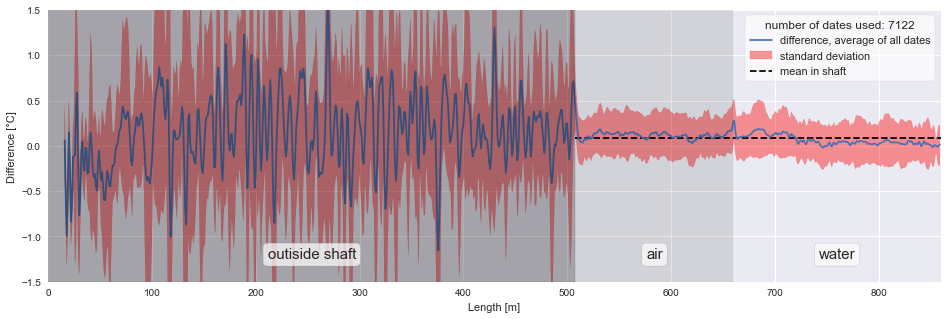

the following plot is not saved, its from the second up down of channel 78
mean diff in shaft: -0.031
Avearaged differences of up and down Temperature from 2021-06-01 to 2021-11-04 with 7122 data points per depth


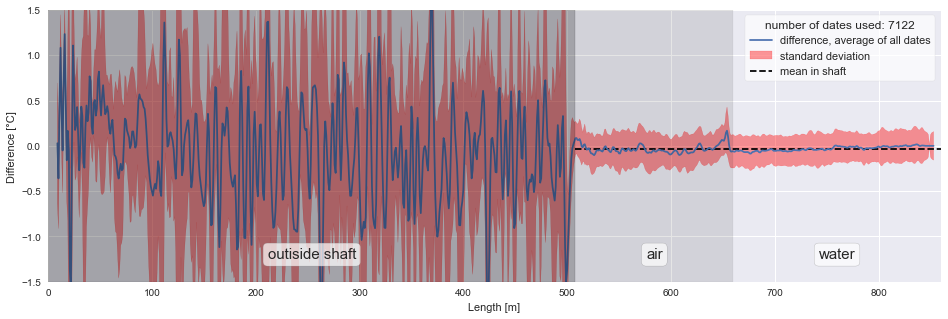



mean std shaft: 0.131
mean diff in shaft: -0.049
Avearaged differences of up and down Temperature from 2021-06-01 to 2021-11-04 with 6646 data points per depth


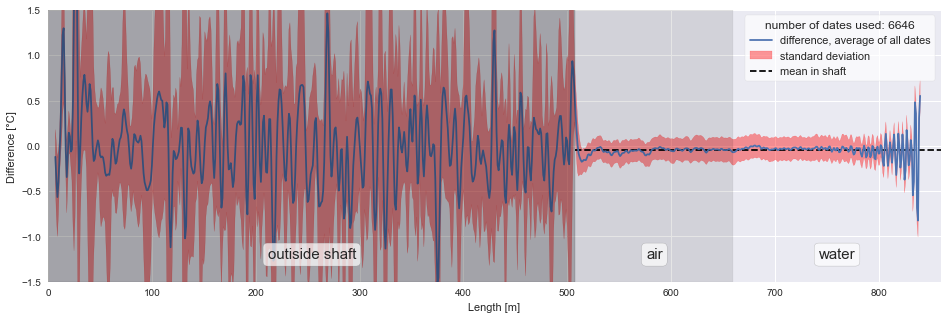

In [167]:
# Plot difference of back and forth from mean channel 7 and 8. These measure the same Positions and therfore there shouldnt be a big difference
# this plot is a comparrisson for the plot in analysis_shaft_temperature.ipynb
def plot_channel_itself_statistic(mean,stdev):
    """"""
    def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name,alpha=0.5, label=True):
            """ creates patches which color the plot"""
            width = end_len - start_len
            Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=abs(ymax)+abs(ymin),color=col,alpha=alpha,zorder=19)
            axs.add_patch(Rectangle)
            if label:
                    #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
                    bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.7)
                    axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=15,bbox=bbox_props,zorder=20)

    ymin=-1.5; ymax=1.5
    fig,axs=plt.subplots(1,1,figsize=(16,5))
    axs.plot(mean.index,mean.values,label="difference, average of all dates")
    axs.fill_between(mean.index,mean.values-stdev.values,mean.values+stdev.values,color="red",alpha=0.4,label=f"standard deviation")

    
    plt.hlines([mean.loc[508:].mean()],508,860,color="black",linestyle="--",label=f"mean in shaft")
    print(f"mean diff in shaft: {round(mean.loc[508:].mean(),3)}")

    # date information
    min_date = diff_for_back.index.min().strftime("%Y-%m-%d")
    max_date = diff_for_back.index.max().strftime("%Y-%m-%d")
    n = len(diff_for_back.index)
    print(f"Avearaged differences of up and down Temperature from {min_date} to {max_date} with {n} data points per depth")

    # Assecoirs
    axs.set_xlabel("Length [m]")
    axs.set_ylabel("Difference [°C]")
    axs.set_ylim(ymin,ymax)
    axs.set_xlim(0,860)
    legend=axs.legend(fontsize=11,frameon=True,title=f"number of dates used: {n}",title_fontsize=12) #, loc='upper center'
    legend.get_frame().set_alpha(0.7) #not supported with eps
    legend.get_frame().set_facecolor("white")
    color_cable_pos(0,508,"black",ymax,ymin,"outiside shaft",alpha=0.3)
    color_cable_pos(508,660,"black",ymax,ymin,"air",alpha=0.1)
    color_cable_pos(660,860,"blue",ymax,ymin,"water",alpha=0.0)

# :1700 and :1700 -1 for complete cable
# is 850 really exactly at the bendpoint?
# bendpoint = 857 #[m] #same bendpoint as in exported shaft temperature
# data= chan_mean_constshift_averagefirst["7and8"][mask_not_egrt_78] #remove egrt dates, not really a influence
# forward_columns = data.columns[:bendpoint-5]
# backward_columns = data.columns[bendpoint-7-3:bendpoint-1+bendpoint-5-1] #-1 manual test, better plot
# forward=data[forward_columns]
# backward=data[backward_columns]
# backward.columns=forward.columns[::-1]
# forward2_columns = data.columns[bendpoint-7+bendpoint-5-1:bendpoint-7+bendpoint-5-1+bendpoint-5]
# backward2_columns = data.columns[bendpoint-7+bendpoint-12+bendpoint-5:] #-1 manual test, better plot
# forward2=data[forward2_columns]
# backward2=data[backward2_columns]
# backward2.columns=forward2.columns[::-1]


#  2207 2906  508 1207

bendpoint=859

manual1=8
manual2=6
forward_col=chan_mean_constshift_averagefirst["7and8"].columns[:bendpoint-5]
backward_col=chan_mean_constshift_averagefirst["7and8"].columns[bendpoint-5-manual1:bendpoint+bendpoint -5-5-manual1]

forward2_col=chan_mean_constshift_averagefirst["7and8"].columns[2557-9-bendpoint+5+manual2:2557-9+manual2]
backward2_col=chan_mean_constshift_averagefirst["7and8"].columns[2557-9-3:]




forward2=chan_mean_constshift_averagefirst["7and8"][forward2_col]
backward2=chan_mean_constshift_averagefirst["7and8"][backward2_col]
forward=chan_mean_constshift_averagefirst["7and8"][forward_col]
backward=chan_mean_constshift_averagefirst["7and8"][backward_col]

backward.columns=forward.columns[::-1]
backward2.columns=forward.columns[::-1]
forward2.columns=forward.columns

diff_for_back = forward - backward  # some nan at begninning due to deleting splice position
diff_for_back2 = forward2 - backward2
diff_for_back2.columns=diff_for_back2.columns-diff_for_back2.columns[0]

# calc mean and standart deviation for every depth
mean=diff_for_back.mean(axis=0)
stdev=diff_for_back.std(axis=0)
print(f"mean std shaft: {round(stdev[520:].mean(),3)}")
mean2=diff_for_back2.mean(axis=0)
stdev2=diff_for_back2.std(axis=0)

# Plot Difference Statistics
plot_channel_itself_statistic(mean,stdev)
if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\channel_itself_statistic_78.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\channel_itself_statistic_78.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\channel_itself_statistic_78.png")
plt.show()

print("the following plot is not saved, its from the second up down of channel 78")
plot_channel_itself_statistic(mean2,stdev2)
plt.show() # not saved, only say that it is very similar

print();print()
# Das gleiche für channel 56
bendpoint = 857 #[m] #same bendpoint as in exported shaft temperature
#adjust columns so they better fit; I think the cable is not optimal alligned

forward_columns = chan_mean_constshift_averagefirst["5and6"].columns[:bendpoint-6]
backward_columns = chan_mean_constshift_averagefirst["5and6"].columns[bendpoint-11:bendpoint-11+bendpoint-6]
forward=chan_mean_constshift_averagefirst["5and6"][forward_columns]
backward=chan_mean_constshift_averagefirst["5and6"][backward_columns]
backward.columns=forward.columns[::-1]

diff_for_back = forward - backward  # some nan at begninning due to deleting splice position

# calc mean and standart deviation for every depth
mean=diff_for_back.mean(axis=0)
stdev=diff_for_back.std(axis=0)
print(f"mean std shaft: {round(stdev[520:].mean(),3)}")

# Plot Difference Statistics
plot_channel_itself_statistic(mean,stdev)
if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\channel_itself_statistic_56.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\channel_itself_statistic_56.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\channel_itself_statistic_56.png")
plt.show()

# standartabweichung am ende relativ konstant, zwigt, dass dort konstant etwas verändert wird



##################################length beschriftung nicht korrekt

# Checks
print farbig machen, relativ weit scrollen scheint eine ugt Lösung zu sein. Noch nicht getestet:
https://stackoverflow.com/questions/16816013/is-it-possible-to-print-using-different-colors-in-ipythons-notebook

In [170]:
# Checks
# check if everything works as expected
# both same result, compare with diff_betweenChan_aftercorr_all_dates, to see that the 19 row in this dataframe 
# is the difference between the measured watertank temperature of the PT-sensor
# (interpolated with a function between the data points)
# first calc
val2=temp_watertank_func([pd.to_datetime('2021-06-07 18:52:39')], df_Tlogger)
val1=temp_watertank_func([pd.to_datetime('2021-06-07 18:56:39')], df_Tlogger)
calc1=val1[0]-val2[0]

# second calc
date_check_ch5='2021-06-07 18:52:39'
timestamp_ch5=pd.Timestamp(date_check_ch5)
date_check_ch6='2021-06-07 18:56:39'
timestamp_ch6=pd.Timestamp(date_check_ch6)
calc2=data_all_processed_shifted["5"][watertank_len[0]][timestamp_ch5] - data_all_processed_shifted["6"][watertank_len[0]][timestamp_ch6]

if abs(calc1) != abs(calc2):
    print("Is there something wrong?");print(calc1);print(calc2)
    print("maybe you changed round in watertank_shift() function")

# Plots

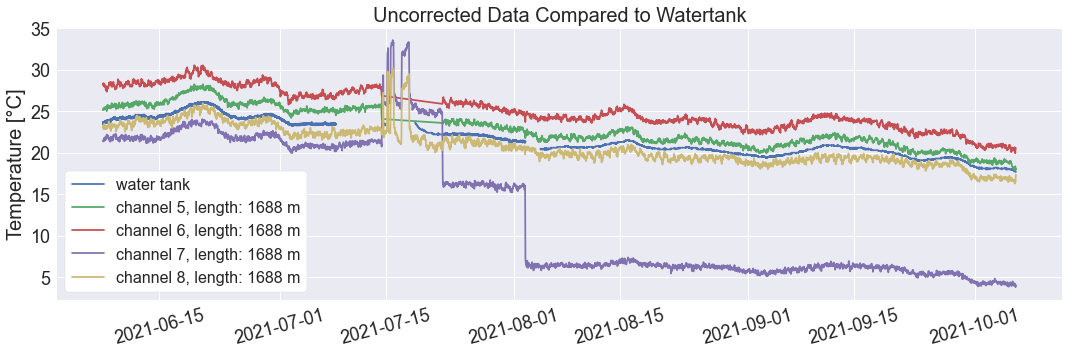

In [171]:
# Compare watertank to uncorrected channels
#ACHTUNG!! bei processing lösche ich einige Werte, sodass index sich ändert!!!
watertank_EGRT = 1688 #1689 # ich muss mir angucken welche Länge bei Mittelung mit dieser gemittelt wird um zu sehen, ob diese Länge
# evntl. schon sußerhalb vom Wassertank ist

#start = 
#end = 15800

fig, axs = plt.subplots(figsize=(18,5))
axs.plot(df_Tlogger.index[:], df_Tlogger["Channel1-Watertank"][:], label="water tank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]: #["7","8"]: #: 
    inde=data_2021[c][str(df_Tlogger.index[:].min()) : str(df_Tlogger.index[:].max())][watertank_EGRT].index
    val=data_2021[c][str(df_Tlogger.index[:].min()) : str(df_Tlogger.index[:].max())][watertank_EGRT].values
    d=data_2021[c][str(df_Tlogger.index[:].min()) : str(df_Tlogger.index[:].max())][watertank_EGRT].name
    axs.plot(inde,val, label=f"channel {c}, length: {d} m")

    # inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].index
    # val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].values
    # plt.plot(inde,val, label=f"channel {c} length {1707-watertank_EGRT}")

font=20
axs.set_ylabel("Temperature [°C]",fontsize=font)
#axs.set_xlabel("Date",fontsize=16)
axs.set_title("Uncorrected Data Compared to Watertank",fontsize=font)
axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
legend = axs.legend(fontsize=font-4, frameon=True)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor("white")

#plt.savefig("pictures/raw_data_compared_to_watertank.png",bbox_inches="tight")
plt.show()

In [172]:
# # diff steigt mit länge des Kabels
# diff=np.abs(corrected_val["7"] - corrected_val["8"])
# diff_clean=np.delete(diff,np.where(diff > 6)) #remove outliers
# leng=len(diff_clean)
# x=np.arange(0,leng)

# plt.plot(x,diff_clean,label="diffs")
# a,b=np.polyfit(x,diff_clean,deg=1)

# plt.plot(x,b+a*x,label="linear fit")
# plt.legend()
# print(f"{a},    {b}")

# water level rise chan 5 - 8

In [173]:
# Resample data
resample_hours=12
col=Schacht_7and8_0_down.columns[145:175]
resample_data=Schacht_7and8_0_down[col].resample(f"{resample_hours}H").mean()

# so both plots have same shape in thesis
col=resample_data.columns[4:]
resample_data[col]

plot_water_rise(resample_data[col],plot_save=masterthesis_save,linear_curve=[156.5,0.008],data_type="chan58",show_additional_water_level_info=False)

fitted water level rise: 2.9 m / year
this is a total of 1.2 m in the measurement time


In [174]:
# Calc diff and determine linear curve at that plot
all_diff_columns=[]
number_of_averages=1
for x in resample_data.columns[:-number_of_averages*2]:
    noa=number_of_averages
    x_index=x-resample_data.columns[0]
    col1=resample_data.columns[x_index:x_index+noa]
    col2=resample_data.columns[x_index+noa:x_index+2*noa]
    diff_colum=resample_data[col2].mean(axis=1) - resample_data[col1].mean(axis=1)
    #diff_colum=resample_data[x] - resample_data[x+1]

    all_diff_columns.append(diff_colum)

df_diff=pd.concat(all_diff_columns,axis=1)
df_diff.columns=resample_data.columns[:-number_of_averages*2]+number_of_averages+0.5
df_diff=round(df_diff,1)

# Plot and save
plot_water_rise(df_diff,plot_save=masterthesis_save,linear_curve=[156.5,0.008],title="Diff.",zminmax=[0,0.5],data_type="chan58",show_additional_water_level_info=False)

fitted water level rise: 2.9 m / year
this is a total of 1.2 m in the measurement time
